In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tensorboardX import SummaryWriter

plt.ion()   # interactive mode
%matplotlib inline

Load Data
---------


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images


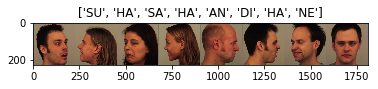

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [4]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, writer=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'saved/densenet.pt')

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [6]:
model_ft = models.densenet161(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

writer = SummaryWriter('./logs/densenet161_full')

### Train and evaluate



In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer,
                       num_epochs=20)

Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:08<00:00,  3.08it/s]


train Loss: 1.0809 Acc: 0.5862


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.78it/s]


val Loss: 0.3566 Acc: 0.8694

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:10<00:00,  3.06it/s]


train Loss: 0.4324 Acc: 0.8472


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.96it/s]


val Loss: 0.2992 Acc: 0.9061

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:09<00:00,  3.07it/s]


train Loss: 0.2670 Acc: 0.9084


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.99it/s]


val Loss: 0.2374 Acc: 0.9061

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:07<00:00,  3.11it/s]


train Loss: 0.2032 Acc: 0.9301


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.14it/s]


val Loss: 0.3512 Acc: 0.8898

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:07<00:00,  3.10it/s]


train Loss: 0.1363 Acc: 0.9557


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.09it/s]


val Loss: 0.1144 Acc: 0.9633

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:06<00:00,  3.12it/s]


train Loss: 0.1095 Acc: 0.9632


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  6.01it/s]


val Loss: 0.1377 Acc: 0.9551

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:06<00:00,  3.12it/s]


train Loss: 0.0570 Acc: 0.9871


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.98it/s]


val Loss: 0.0636 Acc: 0.9837

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:07<00:00,  3.11it/s]


train Loss: 0.0457 Acc: 0.9888


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.96it/s]


val Loss: 0.0633 Acc: 0.9837

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:08<00:00,  3.09it/s]


train Loss: 0.0421 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.92it/s]


val Loss: 0.0670 Acc: 0.9796

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 582/582 [03:07<00:00,  3.10it/s]


train Loss: 0.0411 Acc: 0.9901


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.80it/s]


val Loss: 0.0576 Acc: 0.9878

Epoch 10/19
----------


 44%|██████████████████████████████████▉                                             | 254/582 [01:24<01:48,  3.02it/s]

KeyboardInterrupt: 

# Load and test the model

In [10]:
model_ft.load_state_dict(torch.load('saved/densenet.pt'))
model_ft.eval()

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [11]:
import imageio
total = 0
correct = 0

classes = {
    0 : "AF",
    1 : "AN",
    2 : "DI",
    3 : "HA",
    4 : "NE",
    5 : "SA",
    6 : "SU"
}

for inputs, labels in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    labels = labels.to(device)


    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    
    total+=1
    if labels.data[0].cpu().numpy() == preds.data[0].cpu().numpy():
        correct+=1
    else:
        # save the image
        img = inputs[0].cpu().numpy()
        img = np.ascontiguousarray(img.transpose(1,2,0))
        imageio.imwrite(str(total)+'.jpg', img)
        
        print("image no ", str(total), "  original class : ", classes[int(labels.data[0].cpu().numpy())], "  predicted class: ", classes[int(preds.data[0].cpu().numpy())])

print(correct, total)



  0%|                                                                                          | 0/245 [00:00<?, ?it/s]

  0%|▎                                                                                 | 1/245 [00:01<07:06,  1.75s/it]

  2%|█▎                                                                                | 4/245 [00:01<01:51,  2.16it/s]

image no  6   original class :  AF   predicted class:  SU




  2%|██                                                                                | 6/245 [00:01<01:17,  3.07it/s]

  4%|███                                                                               | 9/245 [00:02<00:54,  4.31it/s]

  5%|███▉                                                                             | 12/245 [00:02<00:43,  5.39it/s]

  6%|████▋                                                                            | 14/245 [00:02<00:38,  6.02it/s]

  7%|█████▌                                                                           | 17/245 [00:02<00:32,  6.95it/s]

  8%|██████▌                                                                          | 20/245 [00:02<00:28,  7.84it/s]

  9%|███████▌                                                                         | 23/245 [00:02<00:25,  8.64it/s]

 11%|████████▌                                                                        | 26/245 [00:02<00:23,  9.39it/s]

 12%|█████████▌               

image no  93   original class :  AF   predicted class:  SU




 38%|███████████████████████████████                                                  | 94/245 [00:05<00:08, 17.94it/s]

 40%|████████████████████████████████                                                 | 97/245 [00:05<00:08, 18.16it/s]

 41%|████████████████████████████████▋                                               | 100/245 [00:05<00:07, 18.37it/s]

 42%|█████████████████████████████████▉                                              | 104/245 [00:05<00:07, 18.65it/s]

 44%|██████████████████████████████████▉                                             | 107/245 [00:05<00:07, 18.85it/s]

 45%|███████████████████████████████████▉                                            | 110/245 [00:05<00:07, 19.04it/s]

 46%|████████████████████████████████████▉                                           | 113/245 [00:05<00:06, 19.16it/s]

 48%|██████████████████████████████████████▏                                         | 117/245 [00:06<00:06, 19.40it/s]

 49%|█████████████████████████

image no  149   original class :  SA   predicted class:  DI




 61%|████████████████████████████████████████████████▋                               | 149/245 [00:07<00:04, 20.74it/s]

 62%|█████████████████████████████████████████████████▋                              | 152/245 [00:07<00:04, 20.83it/s]

 63%|██████████████████████████████████████████████████▌                             | 155/245 [00:07<00:04, 20.88it/s]

 64%|███████████████████████████████████████████████████▌                            | 158/245 [00:07<00:04, 20.98it/s]

 66%|████████████████████████████████████████████████████▌                           | 161/245 [00:07<00:03, 21.08it/s]

 67%|█████████████████████████████████████████████████████▌                          | 164/245 [00:07<00:03, 21.17it/s]

 68%|██████████████████████████████████████████████████████▌                         | 167/245 [00:07<00:03, 21.22it/s]

 69%|███████████████████████████████████████████████████████▌                        | 170/245 [00:07<00:03, 21.27it/s]

 71%|█████████████████████████

242 245
